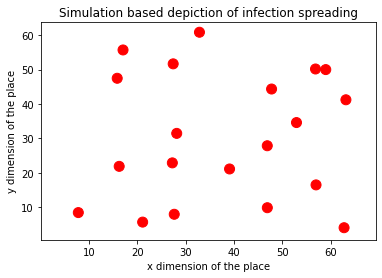

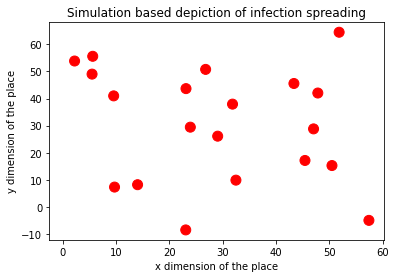

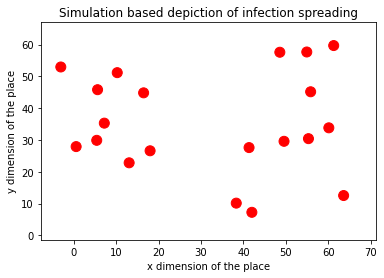

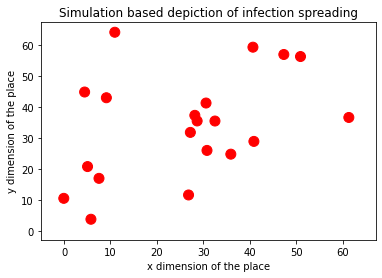

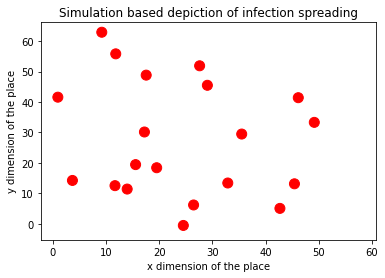

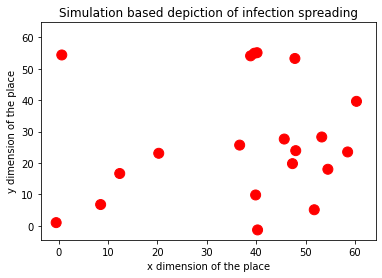

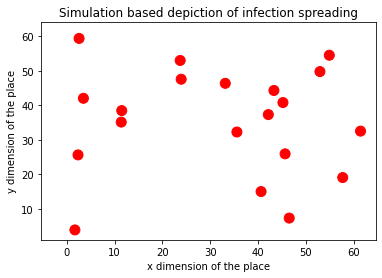

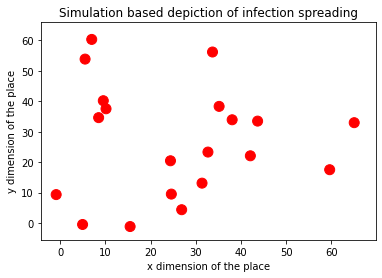

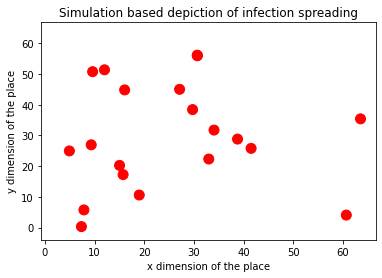

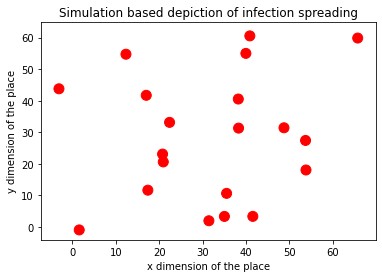

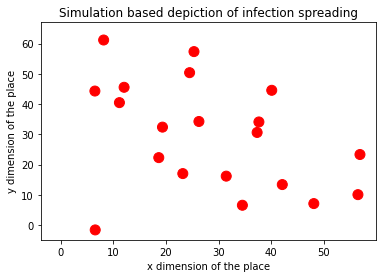

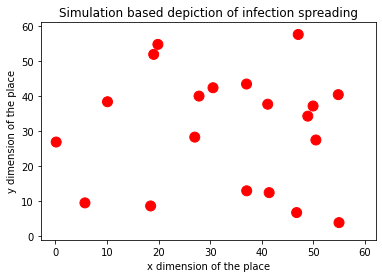

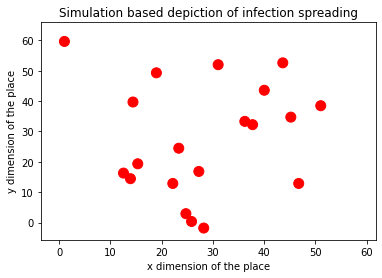

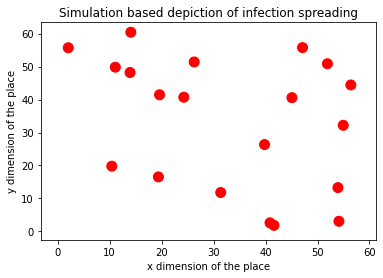

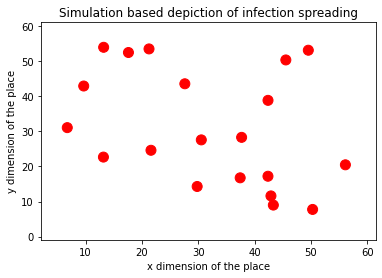

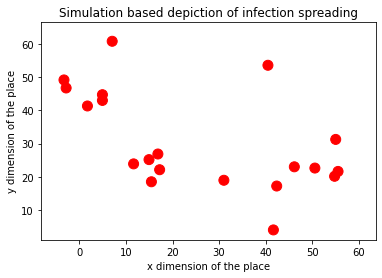

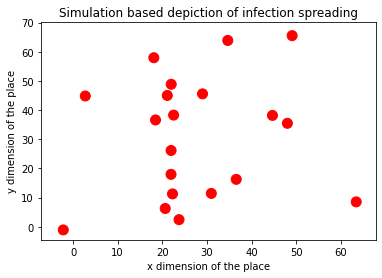

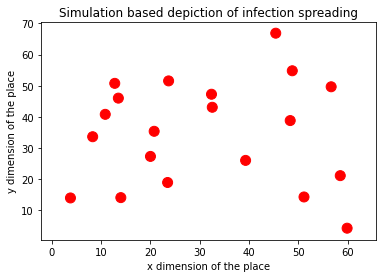

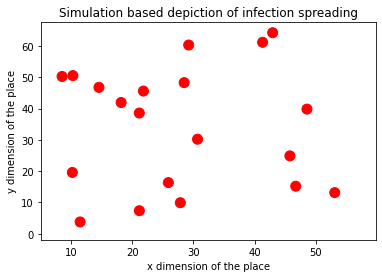

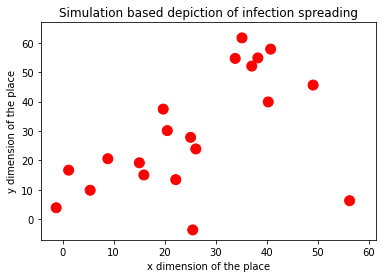

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from celluloid import Camera
from matplotlib import cm
import matplotlib.animation as ani
from matplotlib import rc
from IPython.display import HTML, Image
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

rc('animation', html='html5')

# Inputs/Parameters --------------------------------------------------------------------------

deltat = 1 # units: min
T = 20 # units: min
dmax = 2 # (assumed value) units: m
k = 1/dmax # decay rate
class_size=[60, 60] # units: m^2
num_people=20
po = 1 # max prob
a = 1.5 # units: m
proba_infection=0.05 # initial probability of infection in the room/area
probability_threshold = 0.2 # (assumed value)  the minimum threshold above which the person is marked to be infected
num_infected_per_seed = {} # Dictionary to capture the list of number of infected people per time_step per seed
num_of_seeds = 20 # Number of seeds the simulation must be run for


# Helper Functions ----------------------------------------------------------------------------

def rand_initialize(num_people, class_size):
        
    '''
    The function randomnly initializes positions for a number of people in an area of fixed square dimensions.
    A dictionary of the person's id (a natural number) with the corresponding initial position is returned.
    '''

    sp={}
    for i in range(num_people):
        sp[i] = []
        sp[i].append(np.array([random.sample(list(np.linspace(1, class_size, 2000)), 1)[0], random.sample(list(np.linspace(1, class_size, 2000)), 1)[0]]))
    return sp


def random_move(position, a):

    '''
    The function takes in 2 inputs - the initial position of the person, and the average step he/she takes while moving, 
    in a single time-step.
    It returns the new positions of the same person.
    '''

    x, y = position
    x = x + a*np.cos(2*np.pi*random.random())
    y = y + a*np.sin(2*np.pi*random.random())
    return x, y


def assign_infection(l, prob_infected):

    '''
    The function takes in the probability of getting infected and a list of ids (or names) of people as inputs 
    and returns a dictionary of random people assigned with infections according to a uniform probability passed.
    '''

    num_infected = int(prob_infected*len(l))
    form = {}
    infected = random.sample(l, k=num_infected)
    safe = []
    for i in range(len(l)):
        if l[i] not in infected:
            safe.append(l[i])
    for i in range(len(l)):
        form[l[i]] = []
    for i in infected:
        form[i].append('infected')
    for j in safe:
        form[j].append('safe')
    return form

def infected_list(infected_dict):

    '''
    The function takes in a dictionary of people infected and returns a list of their corresponding ids/names.
    '''

    inf = []
    for k in infected_dict:
        if infected_dict[k][0] == 'infected':
            inf.append(int(k))
    return inf

def prob(k, po, D):

    '''
    The function that captures the infection spreading in the community, depending on their relative positions.
    po: probability of getting infected at least possible distance (very close to 1)
    k: rate of decay of the probability with distance (=1/dmax)
    D: the distance between 2 people 
    '''

    return po*np.e**(-k*D)


# Simulation code ---------------------------------------------------------------------------------

for s in range(num_of_seeds): 
    random.seed(s)
    
    people = rand_initialize(num_people, class_size[0])
    names = [] # list of ids/names of people in the setting
    for i in people:
        names.append(i)
        
    initial_pos = []
    for i in people:
        initial_pos.append(np.array(people[i]).tolist()[0])

    positions = {} # a dictionary to capture the coordinates of each person at different time_steps
    status = {} # a dictionary that captures the initial status (infected/safe) of a person
    d = {} # a dictionary that holds the distance between the infected person and the other people in the room (redundancy is permitted)
    infec = [] # a list that captures all the infected people in different time steps of the same seed
    new_status = {} # the dictionary that captures the updated status (infected/safe) after each time_step
    infected = [] # a list to capture the proportion of people infected during each timestep
    probability_of_getting_infected = {} # dictionary to capture the probabilities of infection for each person after different time_steps according to the probability law assumed
    
    
    infected_dict = assign_infection(names, proba_infection)
    inf = infected_list(infected_dict)
    for t in range(0, T, deltat):
        positions[str(t+1)] = []
        status[str(t+1)] = []
    for t in range(0, T, deltat):
        for j in random.sample(list(people), len(people)): # select a person from the dictionary to be moved
            x, y = random_move(people[j][0], a) # random move
            positions[str(t+1)].append([x, y])
        # move with some proba - assumed to be uniform
            status[str(t+1)].append(infected_dict[j])
        for i in inf:
            for p in positions:
                d['person_id: ' + str(i) + ', ' + 'time_interval: ' + p] = []
                for j in positions[p]:
                      d['person_id: ' + str(i) + ', ' + 'time_interval: ' + p].append(round(np.sqrt((j[0] - positions[p][i-1][0])**2 + (j[1] - positions[p][i-1][1])**2), 3))
        for i in d:
            probability_of_getting_infected[i] = []
            for j in d[i]:
                probability_of_getting_infected[i].append(prob(k, po, j))

        list_status = [v for _, v in probability_of_getting_infected.items()]
        for i in range(int(len(list_status)/len(inf))):
            new_status[str(i+1)] = []
            for j in range(len(list_status[i])):
                try:
                    if list_status[i][j] > probability_threshold and list_status[i+T][j] > probability_threshold:
                        new_status[str(i+1)].append('infected')
                    else:
                        new_status[str(i+1)].append('safe')
                except:
                    pass
        status = new_status
        infected_dict = assign_infection(names, len(np.unique(inf))/len(names))
        inf = np.unique(inf + infected_list(infected_dict)).tolist()
        infected.append(len(inf)/len(people))
        infec.append(inf)
        num_infected_per_seed[s] = []
        for i in infec:
            num_infected_per_seed[s].append(len(i))

# Plotting the behavior ------------------------------------------------------------------------------
         
    col = []
    for i in infec:
        l = ['b']*num_people
        for j in i:
            l[j] = 'r'
        col.append(l)

    points = np.array(initial_pos).reshape(2, -1)
    fig1 = plt.figure()
    ax = fig1.add_subplot()

    camera = Camera(fig1)
    for _ in range(T):
        colors = col[_]
        points[0] += a * np.cos(2*np.pi*np.random.random((num_people, )))
        points[1] += a * np.sin(2*np.pi*np.random.random((num_people, )))
        plt.scatter(*points, c=colors, s=100)
        plt.title('Simulation based depiction of infection spreading')
        plt.xlabel('x dimension of the place')
        plt.ylabel('y dimension of the place')
        camera.snap()
    anim = camera.animate(blit=True, interval=500, repeat=False)
    Writer = ani.writers['ffmpeg']
    writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)
    anim.save('animations' + str(s) + '.mp4', writer=writer)
        
        

In [2]:
intermediate = {} # Dict to capture the number of infections in each timestep
avg_over_timesteps_final = {} 
std_over_timesteps_final = {}
for t in range(0, T, deltat):
    intermediate[t] = []
    for j in num_infected_per_seed:
        intermediate[t].append(np.mean(num_infected_per_seed[j][t]))
for t in range(0, T, deltat):
    avg_over_timesteps_final[t] = []
    std_over_timesteps_final[t] = []
    avg_over_timesteps_final[t].append(np.mean(intermediate[t]))
    std_over_timesteps_final[t].append(np.std(intermediate[t]))

In [3]:
avg = [x[0] for x in list(avg_over_timesteps_final.values())]
std = [y[0] for y in list(std_over_timesteps_final.values())]

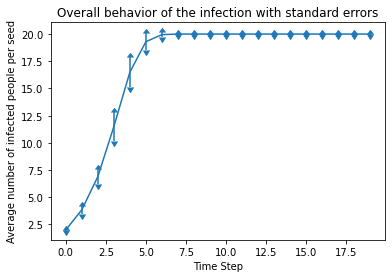

In [4]:
# Plot of average infection numbers per seed with standard errors marked with the arrows
fig2 = plt.figure()
plt.errorbar(list(avg_over_timesteps_final.keys()), avg, yerr = std, uplims=10, lolims=10)
plt.ylabel('Average number of infected people per seed')
plt.xlabel('Time Step')
plt.title('Overall behavior of the infection with standard errors')
plt.savefig('Overall behavior of the infection with standard errors')

In [5]:
# A secondary function to give a rough estimate of number students to be accomodated in a stationary sitting (a classroom) following some norms

# Can we accomodate these many people in a place, assuming them to be almost stationary throughout.

def can_accomodate(place_size, dist_norm, air_space_class=[2, 3], air_space_people=1):
    '''
    place_size (list): [length, breadth]
    dist_norm: min_distance between people to be followed
    air_space_people: comfort+size..etc.
    air_space_class (list): class_room size not used [length, breadth]
    '''        
    return int(((place_size[0]-2*air_space_class[0])*(place_size[1]-2*air_space_class[1]))/((air_space_people/2 + dist_norm)**2))
can_accomodate(place_size=[30, 30], dist_norm=2)

99